# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import datetime
import time
from IPython.display import clear_output

import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from scipy.spatial.transform import Rotation as R
from utils import *

from grace.utils import *

# Initialization

In [2]:
calib_params = load_json('config/calib/calib_params.json')

pan_direction: {
    0: 'left_left',
    1: 'left_right',
    2: 'right_left',
    3: 'right_right',
}
    
tilt_direction: {
    0: 'down_down',
    1: 'down_up',
    2: 'up_down',
    3: 'up_up',
}
    
chessboard_size = (9,6)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#7fff00', '#d2b48c', '#000080']

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_phi_direction(theta, theta_tminus1, data, i):
    phi_direction = None
    try:
        if data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 0
        elif data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 1
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 2
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 3
    except:
        phi_direction = 0
    return phi_direction

def get_chess_corners(img, camera_mtx, dist_coef):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    # Subcorner Pixel Accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(gray, corners, (9,9), (-1,-1), criteria)
    corners = corners.squeeze()
    
    return corners

def get_chess_obj_pts(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]

    obj_pts = []
    for i,(u,v) in enumerate(corners):
        z = depth_list[i]/1000.0
        if z==0:
            z = depth_mean
        x = ((u-cx)/fx)*z
        y = ((v-cy)/fy)*z
        obj_pts.append([x, y, z])
        
    return np.array(obj_pts)

def get_camera_pose(img, obj_pts, camera_mtx, dist_coef):
    # Get corners
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    
    # Estimate the extrinsic matrix
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef)
    retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, flags=cv2.SOLVEPNP_SQPNP )
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, rvec, tvec=np.array([0,0,0.25]), useExtrinsicGuess = True)
    
    # Convert the rotation vector to a rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    
    # Homogeneous Coordinates
    H = np.eye(4)
    H[:3,:3] = rotation_matrix
    H[:3,-1] = tvec.T
    
    # Camera Pose
    T = np.linalg.inv(H)
    return T
    
def depth_to_pointcloud(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    if z==0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,y,z

def transform_points(pts, T_mtx):
    new_obj_pts = []
    for pt in pts:
        temp_pt = np.append(pt, 1).reshape(-1,1)
        temp_pt2 = (T_mtx @ temp_pt).squeeze()
        new_obj_pts.append(temp_pt2[:3])
    new_obj_pts = np.array(new_obj_pts)
    return new_obj_pts

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Loading of Data

## Pickle Data

In [3]:
filename = 'pantilt_baseline_eval_pickle_20240416_235316_907407.pickle'

In [4]:
fn_path = os.path.join(os.getcwd(), 'results', 'pantilt_baseline_eval',filename)
data = read_pickle_file(fn_path)
data = data['data']

In [5]:
pickle_df = pd.DataFrame(data)

In [6]:
pickle_df['theta_left_pan_cmd']

0      -18.000000
1        5.379401
2      -18.000000
3        5.337307
4      -18.000000
          ...    
1195     3.715436
1196   -18.000000
1197    -3.122145
1198   -18.000000
1199     5.383826
Name: theta_left_pan_cmd, Length: 1200, dtype: float64

## Preprocessing



In [7]:
# Assigning next step data for tminus1

pickle_df['theta_left_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_left_pan_cmd'][:-2].tolist() 
pickle_df['theta_right_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_right_pan_cmd'][:-2].tolist() 
pickle_df['theta_tilt_cmd_tminus2'] = [0,0] + pickle_df['theta_tilt_cmd'][:-2].tolist()
pickle_df['theta_left_pan_cmd_tminus1'] = [0] + pickle_df['theta_left_pan_cmd'][:-1].tolist() 
pickle_df['theta_right_pan_cmd_tminus1'] = [0] + pickle_df['theta_right_pan_cmd'][:-1].tolist() 
pickle_df['theta_tilt_cmd_tminus1'] = [0] + pickle_df['theta_tilt_cmd'][:-1].tolist()
pickle_df['chess_idx_tminus1'] = [0] + pickle_df['chess_idx'][:-1].tolist() 
pickle_df['theta_left_pan_tminus1'] = [0] + pickle_df['theta_left_pan'][:-1].tolist() 
pickle_df['theta_right_pan_tminus1'] = [0] + pickle_df['theta_right_pan'][:-1].tolist() 
pickle_df['theta_tilt_tminus1'] = [0] + pickle_df['theta_tilt'][:-1].tolist()
pickle_df['plan_phi_left_pan_tminus2'] = [0,0] + pickle_df['plan_phi_left_pan'][:-2].tolist()
pickle_df['plan_phi_right_pan_tminus2'] = [0,0] + pickle_df['plan_phi_right_pan'][:-2].tolist()
pickle_df['plan_phi_tilt_tminus2'] = [0,0] + pickle_df['plan_phi_tilt'][:-2].tolist()
pickle_df['plan_phi_left_pan_tminus1'] = [0] + pickle_df['plan_phi_left_pan'][:-1].tolist()
pickle_df['plan_phi_right_pan_tminus1'] = [0] + pickle_df['plan_phi_right_pan'][:-1].tolist()
pickle_df['plan_phi_tilt_tminus1'] = [0] + pickle_df['plan_phi_tilt'][:-1].tolist()

In [8]:
# Phi Direction

phi_direction_left_pan_list = [0] + [get_phi_direction(theta='plan_phi_left_pan_tminus1',
                                                       theta_tminus1='plan_phi_left_pan_tminus2',
                                                       data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_right_pan_list = [0] + [get_phi_direction(theta='plan_phi_right_pan_tminus1',
                                                        theta_tminus1='plan_phi_right_pan_tminus2',
                                                        data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_tilt_list = [0] + [get_phi_direction(theta='plan_phi_tilt_tminus1',
                                                   theta_tminus1='plan_phi_tilt_tminus2',
                                                   data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]

pickle_df['phi_direction_left_pan'] = phi_direction_left_pan_list
pickle_df['phi_direction_right_pan'] = phi_direction_right_pan_list
pickle_df['phi_direction_tilt'] = phi_direction_tilt_list

In [9]:
pickle_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_pan_angle', 'chest_tilt_angle', 'plan_phi_left_pan',
       'plan_phi_right_pan', 'plan_phi_tilt', 'chest_img', 'left_eye_img',
       'right_eye_img', 'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'theta_left_pan_cmd',
       'theta_right_pan_cmd', 'theta_tilt_cmd', 'theta_left_pan_cmd_tminus2',
       'theta_right_pan_cmd_tminus2', 'theta_tilt_cmd_tminus2',
       'theta_left_pan_cmd_tminus1', 'theta_right_pan_cmd_tminus1',
       'theta_tilt_cmd_tminus1', 'chess_idx_tminus1', 'theta_left_pan_tminus1',
       't

In [10]:
# Dropping the first row
pickle_df = pickle_df.drop(np.arange(0,2)).reset_index(drop=True)
pickle_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,50,5.009766,1.757812,-10.722656,491.156067,158.063812,359.013550,227.126083,223.766083,237.991516,...,21.884766,8.660739,3.898858,4.638716,8.660739,3.898858,4.638716,3,3,3
1,50,-16.962891,-17.050781,21.796875,493.338806,243.730881,-360.600000,-224.700000,-222.300000,-235.900000,...,-10.722656,8.660739,3.898858,4.638716,8.591895,3.612723,12.843171,2,2,3
2,13,4.833984,1.582031,-29.091797,493.329224,243.747879,366.111053,228.178314,230.635849,239.624741,...,21.796875,8.591895,3.612723,12.843171,8.592968,3.619098,12.821302,1,1,2
3,13,-16.875000,-17.138672,21.884766,461.869110,130.304214,-360.600000,-224.700000,-222.300000,-235.900000,...,-29.091797,8.592968,3.619098,12.821302,5.975147,1.250352,1.880297,2,2,0
4,40,3.339844,0.175781,-4.306641,461.892059,130.271759,358.782043,227.111084,222.994904,237.583664,...,21.884766,5.975147,1.250352,1.880297,5.973998,1.243880,1.903003,0,0,1


# Filtering

In [11]:
temp_df = pickle_df[(pickle_df['theta_left_pan_cmd_tminus1']>-13) & (pickle_df['theta_left_pan_cmd_tminus1']<13) ].reset_index(drop=True)
filt_df = temp_df[(abs(temp_df['dx_l'])<100) & (abs(temp_df['dy_l'])<100) & (abs(temp_df['dx_r'])<100) & (abs(temp_df['dy_r'])<100) ].reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,50,5.009766,1.757812,-10.722656,491.156067,158.063812,359.013550,227.126083,223.766083,237.991516,...,21.884766,8.660739,3.898858,4.638716,8.660739,3.898858,4.638716,3,3,3
1,13,4.833984,1.582031,-29.091797,493.329224,243.747879,366.111053,228.178314,230.635849,239.624741,...,21.796875,8.591895,3.612723,12.843171,8.592968,3.619098,12.821302,1,1,2
2,40,3.339844,0.175781,-4.306641,461.892059,130.271759,358.782043,227.111084,222.994904,237.583664,...,21.884766,5.975147,1.250352,1.880297,5.973998,1.243880,1.903003,0,0,1
3,14,3.251953,0.175781,-23.027344,463.857361,215.529587,361.391144,226.364258,224.766418,237.165863,...,21.796875,5.900489,0.970492,10.103476,5.900489,0.970492,10.103476,1,1,3
4,19,5.009766,1.669922,-4.130859,490.445862,129.581329,358.479095,228.027084,223.788422,238.848907,...,21.796875,8.651169,3.965571,1.892537,8.652740,3.974890,1.859282,3,3,0


In [12]:
print(filt_df['theta_left_pan_cmd_tminus1'].unique())
print(filt_df['theta_right_pan_cmd_tminus1'].unique())
print(filt_df['theta_tilt_cmd_tminus1'].unique())

[ 5.37940067  5.33730688  3.71059875  3.6649407   5.37443225 -1.41435879
  3.66880294  0.25919781 -3.18613845  8.67325983  0.31338151  0.31015649
  3.7154362   8.67240418  8.71395743  5.38481739 -1.35205372  1.93290041
  8.6718308   3.66771422  5.37972942  3.71614617  3.71436579 -1.41364761
  7.07461677 -3.1874508  -3.1251048  -3.05822335  7.06574731  7.03908855
 -3.06040281  0.31259229 -3.12344094  0.26038218  3.70705177  7.03970077
  0.19855006  7.08403655  1.98372482  0.30890151  2.04199961  3.66049902
  5.33664016  3.66844078  7.04881097  5.38605524 -1.47141175  0.31455936
  8.72140368  0.30935183  1.93259865 -3.06084139  8.71480252 -3.12300804
  5.38415737  2.04087684  8.72225617  8.72253917  8.70257281  5.42666586
  3.66386391  1.93451302  1.9888754   5.38741742 -3.12085666  5.3880943
 -1.47075503  1.9833487   1.93365843  1.98221574  7.0494198  -3.12730728
  8.67411026  1.93374962 -1.47057545 -1.40672998  5.38038492  2.04125185
 -3.18877122  0.25449553  5.33763923 -1.41563344  3.

# Initialization

In [13]:
calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")

In [14]:
left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

# Accuracy

## Left Eye

Text(0.5, 1.0, 'Left Eye')

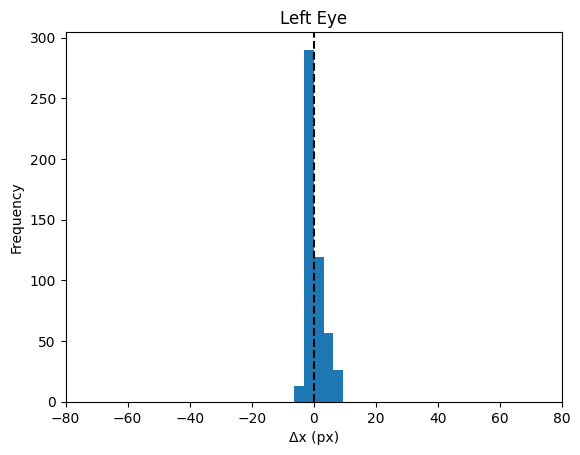

In [15]:
plt.hist(filt_df['dx_l'], range=(-80,80), bins=50)
plt.axvline(0, linestyle='--', color='black')
plt.xlim([-80,80])
plt.xlabel('Δx (px)')
plt.ylabel('Frequency')
plt.title("Left Eye")

Text(0.5, 1.0, 'Left Eye')

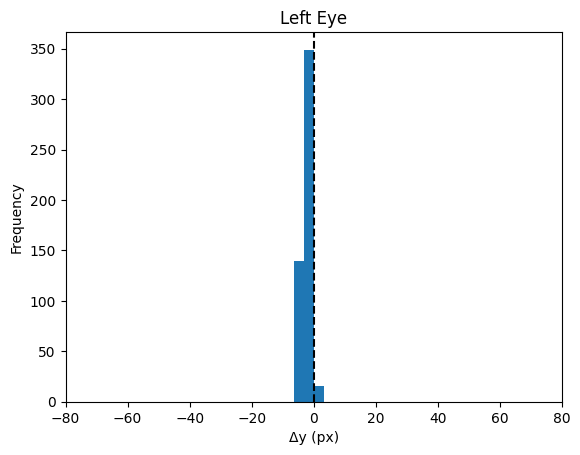

In [16]:
plt.hist(filt_df['dy_l'], range=(-80,80), bins=50)
plt.axvline(0, linestyle='--', color='black')
plt.xlim([-80,80])
plt.xlabel('Δy (px)')
plt.ylabel('Frequency')
plt.title("Left Eye")

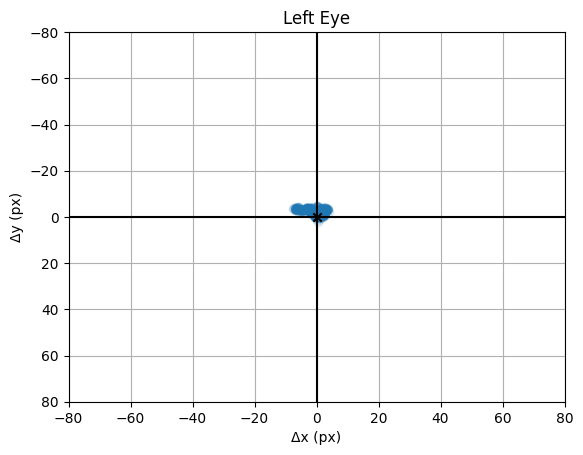

In [17]:
plt.figure()
plt.scatter(-filt_df['dx_l'],filt_df['dy_l'], alpha=0.1)
plt.xlim([-80,80])
plt.ylim([80,-80])
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(0, 0, marker='x', color='black')
plt.title('Left Eye')
plt.xlabel('Δx (px)')
plt.ylabel('Δy (px)')
plt.grid()

In [18]:
# Looping for Policy Plot

# Data
data = filt_df
dx = 'dx_l'
dy = 'dy_l'

delta_x_list = []
delta_y_list = []
for chess_idx in range(54):
    idxs = [i for i,val in enumerate(data['chess_idx_tminus1']) if val==chess_idx]
    after_px_x =-np.array([data[dx][i] for i in idxs])
    after_px_y = np.array([data[dy][i] for i in idxs])
    delta_x_list.append(after_px_x)
    delta_y_list.append(after_px_y)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_6666/584791953.py:151: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)
/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jaynieles/dev/aec/venv/lib/python3.8

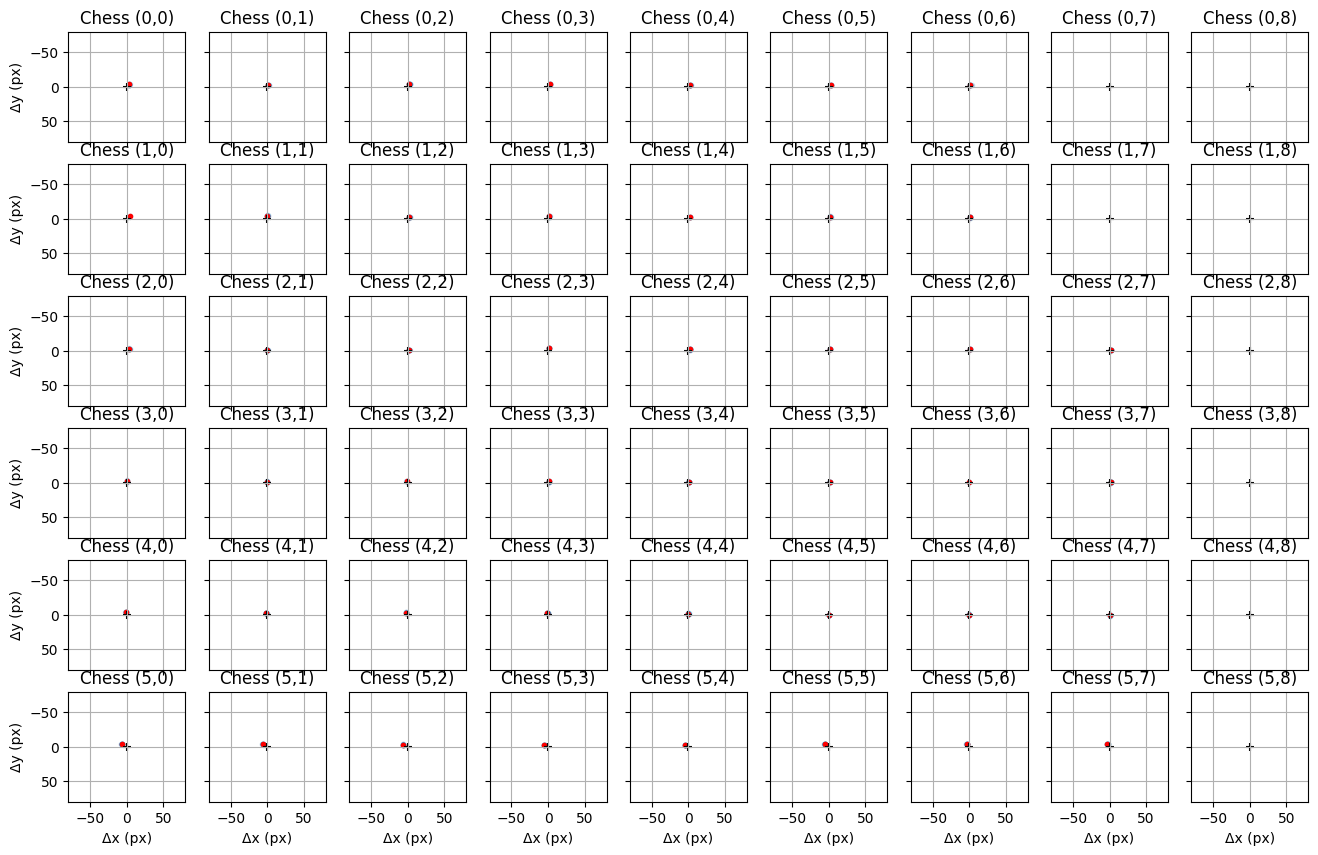

In [19]:
# Scatter Plot

fig, axs = plt.subplots(6, 9, figsize=(16,10))
x_std_list = []
y_std_list = []
for i,ax_i in enumerate(axs.flat):
    ax_i.scatter(delta_x_list[i], delta_y_list[i], marker='.', color='#1f77b4', alpha=0.2)
    confidence_ellipse(x=delta_x_list[i], y=delta_y_list[i], ax=ax_i, n_std=1.0, edgecolor='red')
    x_std_list.append(np.std(delta_x_list[i]))
    y_std_list.append(np.std(delta_y_list[i]))
    ax_i.scatter(delta_x_list[i].mean(), delta_y_list[i].mean(), marker='.', color='red')
    ax_i.scatter(0, 0, marker='+', color='black')
    ax_i.set_xlim(-80,80)
    ax_i.set_ylim(80, -80)
    ax_i.set_title('Chess (%i,%i)' % (i//9,i%9 ))
    ax_i.grid(True)

for ax in axs.flat:
    ax.set(xlabel='Δx (px)', ylabel='Δy (px)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Right Eye

Text(0.5, 1.0, 'Right Eye')

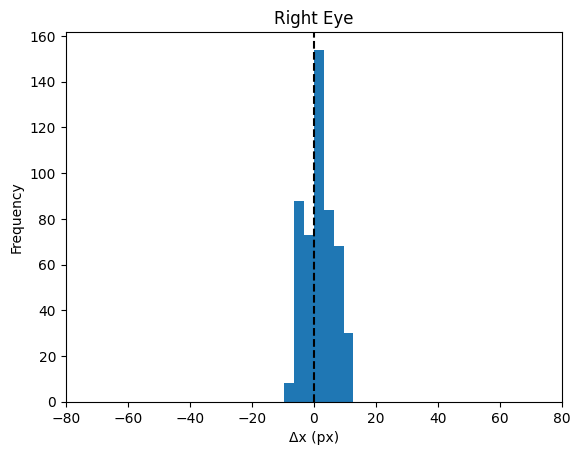

In [20]:
plt.hist(filt_df['dx_r'], range=(-80,80), bins=50)
plt.axvline(0, linestyle='--', color='black')
plt.xlim([-80,80])
plt.xlabel('Δx (px)')
plt.ylabel('Frequency')
plt.title("Right Eye")

Text(0.5, 1.0, 'Right Eye')

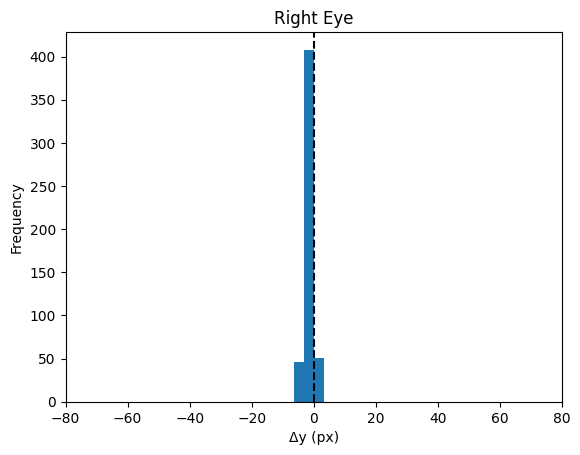

In [21]:
plt.hist(filt_df['dy_r'], range=(-80,80), bins=50)
plt.axvline(0, linestyle='--', color='black')
plt.xlim([-80,80])
plt.xlabel('Δy (px)')
plt.ylabel('Frequency')
plt.title("Right Eye")

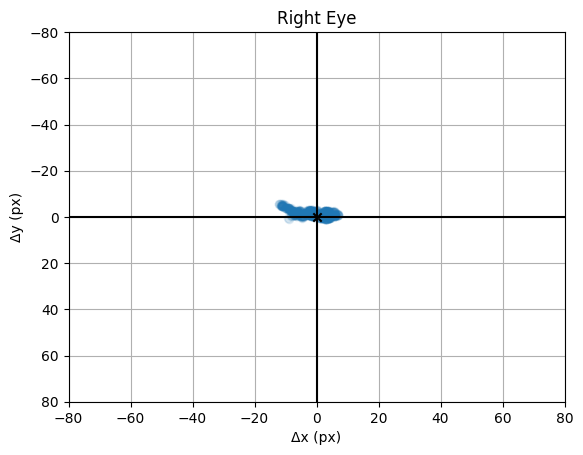

In [22]:
plt.figure()
plt.scatter(-filt_df['dx_r'],filt_df['dy_r'], alpha=0.1)
plt.xlim([-80,80])
plt.ylim([80,-80])
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(0, 0, marker='x', color='black')
plt.title('Right Eye')
plt.xlabel('Δx (px)')
plt.ylabel('Δy (px)')
plt.grid()

In [23]:
# Looping for Policy Plot

# Data
data = filt_df
dx = 'dx_r'
dy = 'dy_r'

delta_x_list = []
delta_y_list = []
for chess_idx in range(54):
    idxs = [i for i,val in enumerate(data['chess_idx_tminus1']) if val==chess_idx]
    after_px_x = -np.array([data[dx][i] for i in idxs])
    after_px_y = np.array([data[dy][i] for i in idxs])
    delta_x_list.append(after_px_x)
    delta_y_list.append(after_px_y)

/tmp/ipykernel_6666/584791953.py:151: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)
/tmp/ipykernel_6666/2817546253.py:11: RuntimeWarning: Mean of empty slice.
  ax_i.scatter(delta_x_list[i].mean(), delta_y_list[i].mean(), marker='.', color='red')


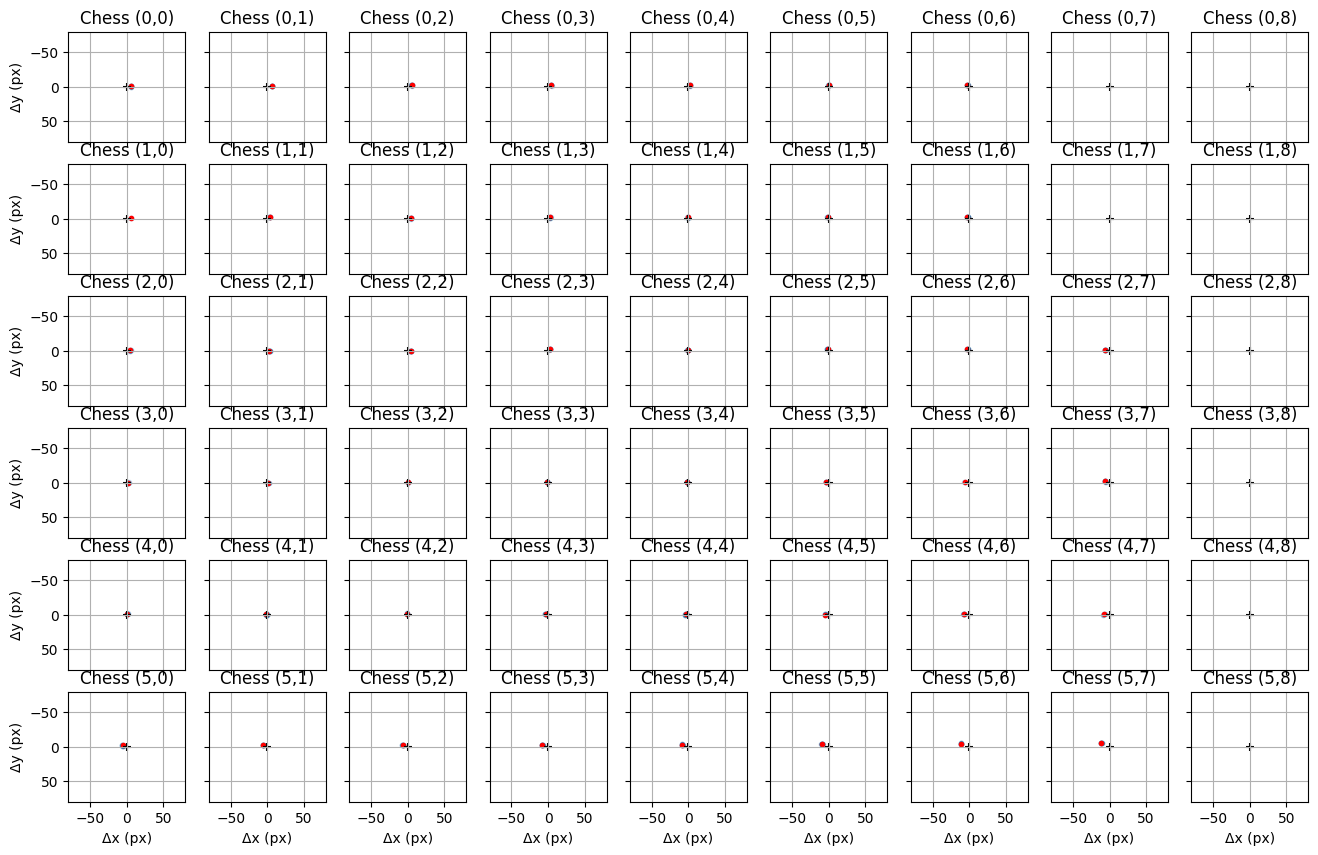

In [24]:
# Scatter Plot

fig, axs = plt.subplots(6, 9, figsize=(16,10))
x_std_list = []
y_std_list = []
for i,ax_i in enumerate(axs.flat):
    ax_i.scatter(delta_x_list[i], delta_y_list[i], marker='.', color='#1f77b4', alpha=0.2)
    x_std_list.append(np.std(delta_x_list[i]))
    y_std_list.append(np.std(delta_y_list[i]))
    confidence_ellipse(x=delta_x_list[i], y=delta_y_list[i], ax=ax_i, n_std=1.0, edgecolor='red')
    ax_i.scatter(delta_x_list[i].mean(), delta_y_list[i].mean(), marker='.', color='red')
    ax_i.scatter(0, 0, marker='+', color='black')
    ax_i.set_xlim(-80,80)
    ax_i.set_ylim(80, -80)
    ax_i.set_title('Chess (%i,%i)' % (i//9,i%9 ))
    ax_i.grid(True)

for ax in axs.flat:
    ax.set(xlabel='Δx (px)', ylabel='Δy (px)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()